In [60]:
# Analyse supply chain data from kaggle
# Source: https://www.kaggle.com/abdelrahmancae/supply-chain-analysis-and-modeling

In [61]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import re

In [62]:
# Import dataset
df = pd.read_csv("SCMS_Delivery_History_Dataset.csv")

In [63]:
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [97]:
# Create utility functions for data cleaning

# Determine column headers
def printColumns(df):
    columns = list(df.columns)
    return print(f"Columns are {','.join(list(df.columns))}")

# Determine data type for each column
def dataType(df):
    records = df.shape[0]
    columns = list(df.columns)
    dtypes = [str(df[x].dtype) for x in columns]
    columnNull = [(df[x].isnull().sum())*100/records for x in columns]
    # Determine number of unique values in each column, i.e. cardinality
    columnCardinality = [len(df[x].unique()) for x in columns]
    columnType = list(zip(columns, dtypes, columnNull, columnCardinality))
    columnDf = pd.DataFrame(columnType, columns = ['Column', 'Dtype', 'Percentage_Null', 'Cardinality'])
    print(columnDf)
    return columnDf, columnType

# Drop columns with more than maximum percentage of nulls
def dropColumn(df, columnDf, cut_off = 5):
    df = df.copy()
    for i in columnDf.iterrows():
        if i[1]['Percentage_Null'] >= 5:
            df.drop([i[1]['Column']], axis = 1, inplace = True)
            print(f"Dropped column {i[1]['Column']} with {i[1]['Percentage_Null']}% of nulls.")
    return df

# Determine if there exists date columns and convert their data type to datetime if not datetime type
def dateColumns(df, columnType):
    df = df.copy()
    pattern = re.compile(r'^\d')
    dateList = []
    dateType = []
    for i in [x for x in columnType]:
        if 'date' in str(i[0]).lower():
            if str(type(i[1])) != 'datetime.date':
                value = df[i[0]].mode().values[0]
                try: 
                    flag = pattern.match(str(value)).group()
                    columnName = i[0] + '_datetime'
                    df[columnName] = df[i[0]].apply(lambda x: datetime.strptime(x, '%d-%b-%y'))
                    print(f"Added column {columnName} as datetime type.")
                except:
                    pass
    return df         

def costColumns(df, columnType):
    df = df.copy()
    pattern = re.compile(r'^\d')
    costList = []
    costType = []
    for i in [x for x in columnType]:
        if 'cost' in str(i[0]).lower():
            if str(type(i[1])) != 'float':
                value = df[i[0]].mode().values[0]
                try: 
                    flag = pattern.match(str(value))
                    columnName = i[0] + '_float'
                    df[columnName] = df[i[0]].apply(lambda x: float(x) if pattern.match(x) else 0)
                    print(f"Added column {columnName} as float type.")
                except:
                    pass
    return df         

def cleanPipeline(df):
    printColumns(df)
    columnDf, columnType = dataType(df)
    df = dropColumn(df, columnDf)
    df = dateColumns(df, columnType)
    df = costColumns(df, columnType)
    return df, columnDf

In [98]:
df, columnDf = cleanPipeline(df)

Columns are ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Scheduled Delivery Date_datetime,Delivered to Client Date_datetime,Delivery Recorded Date_datetime,Freight Cost (USD)_float
                               Column           Dtype  Percentage_Null  \
0                                  ID           int64         0.000000   
1                        Project Code          object         0.000000   
2                                PQ #          object         0.000000   
3                           PO / SO #          object     

In [99]:
# Create functions to add features
def lateDelivery(df):
    df = df.copy()
    df['isLate'] = df['Delivered to Client Date_datetime'] - df['Scheduled Delivery Date_datetime']
    df['isLate'] = df['isLate'].apply(lambda x: 1 if x.days > 0 else 0)
    return df

def madeProfit(df):
    df = df.copy()
    df['Profit'] = df['Line Item Value'] - (df['Line Item Insurance (USD)'].fillna(0) + df['Freight Cost (USD)_float'])
    df['isLoss'] = df['Profit'].apply(lambda x: 1 if x < 0 else 0)
    return df

def featuresPipeline(df):
    dfNew = lateDelivery(df)
    dfNew = madeProfit(dfNew)
    print(f"{dfNew.shape[1] - df.shape[1]} features added.")
    return dfNew

In [103]:
df = featuresPipeline(df)
df, columnDf = cleanPipeline(df)

0 features added.
Columns are ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Scheduled Delivery Date_datetime,Delivered to Client Date_datetime,Delivery Recorded Date_datetime,Freight Cost (USD)_float,isLate,Profit,isLoss
                               Column           Dtype  Percentage_Null  \
0                                  ID           int64         0.000000   
1                        Project Code          object         0.000000   
2                                PQ #          object         0.000000   
3                  

In [104]:
# Create functions to plot data
def categoricalPlot(df, columnDf, cut_off = 50):
    for i in columnDf.iterrows():
        try:
            if i[1]['Cardinality'] < cut_off:
                df.groupby([i[1]['Column']]).count()['ID'].reset_index(drop = False).sort_values(by = ['ID'], ascending = True).plot.barh(x = i[1]['Column'], y = 'ID', figsize = (15, 10), title = f"Number of records by {i[1]['Column']}")
        except:
            pass

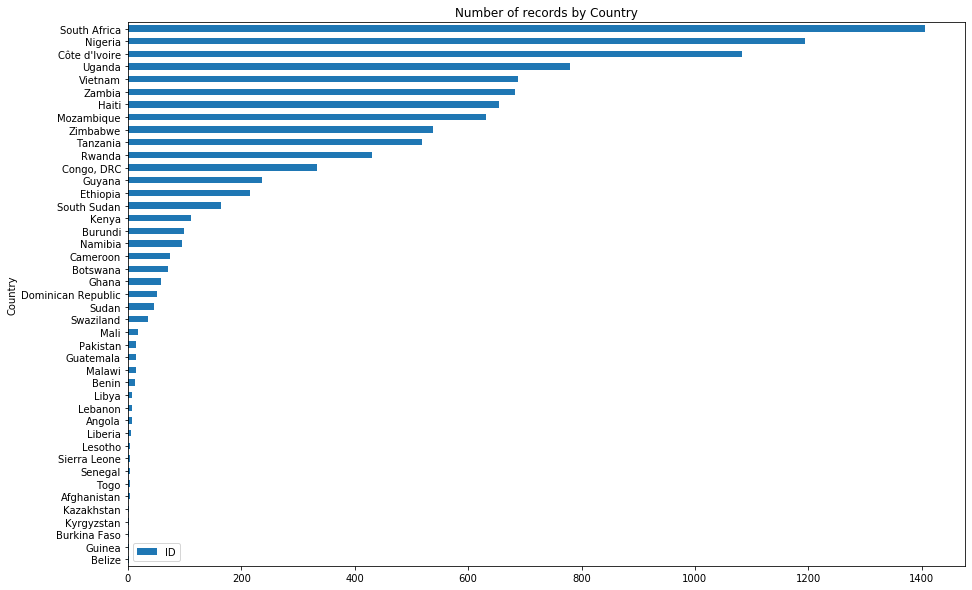

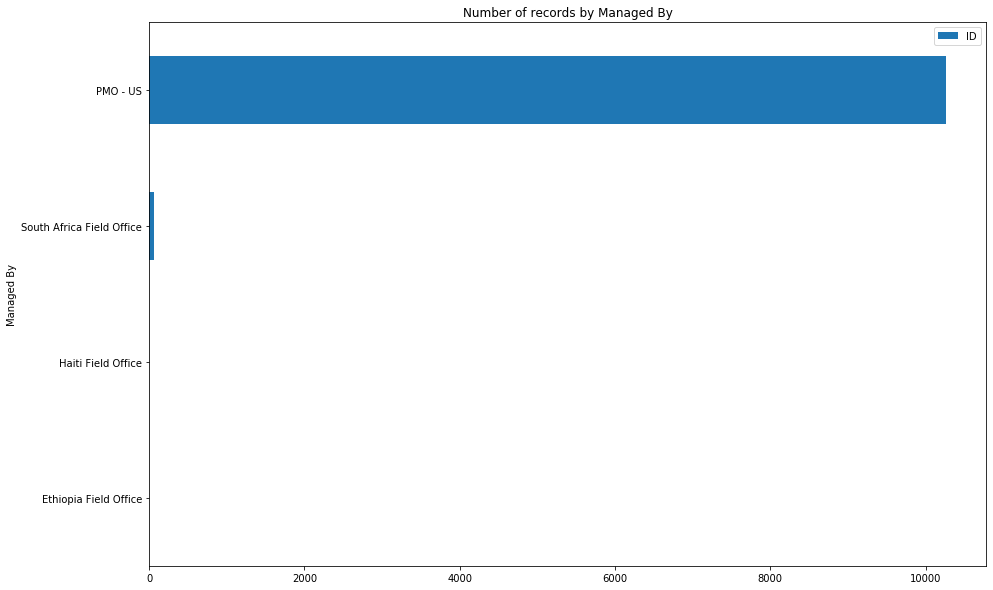

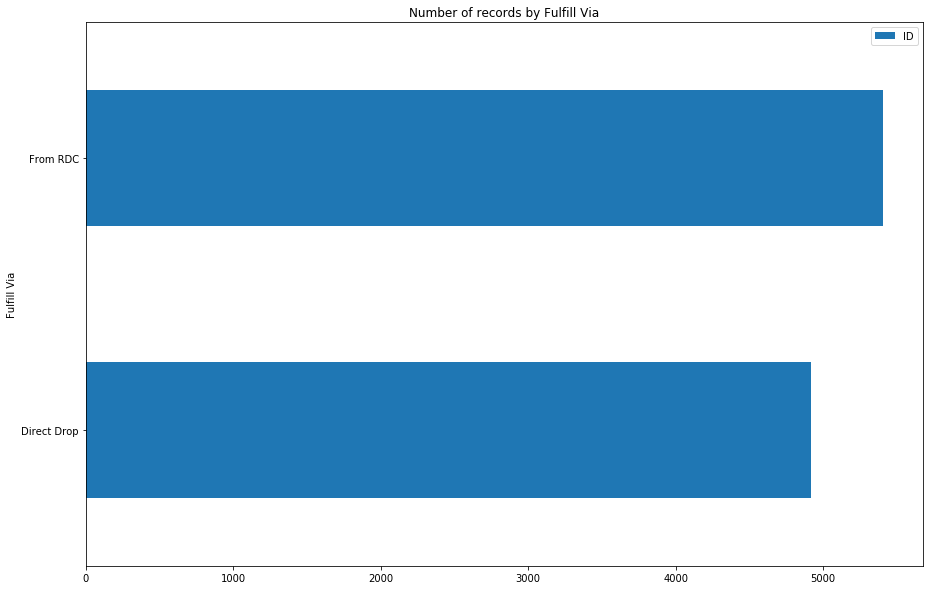

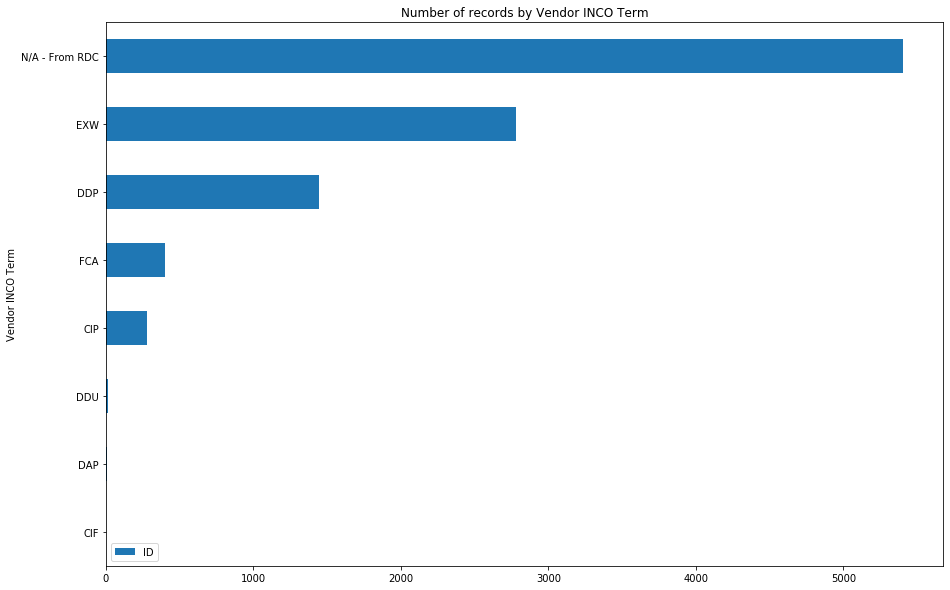

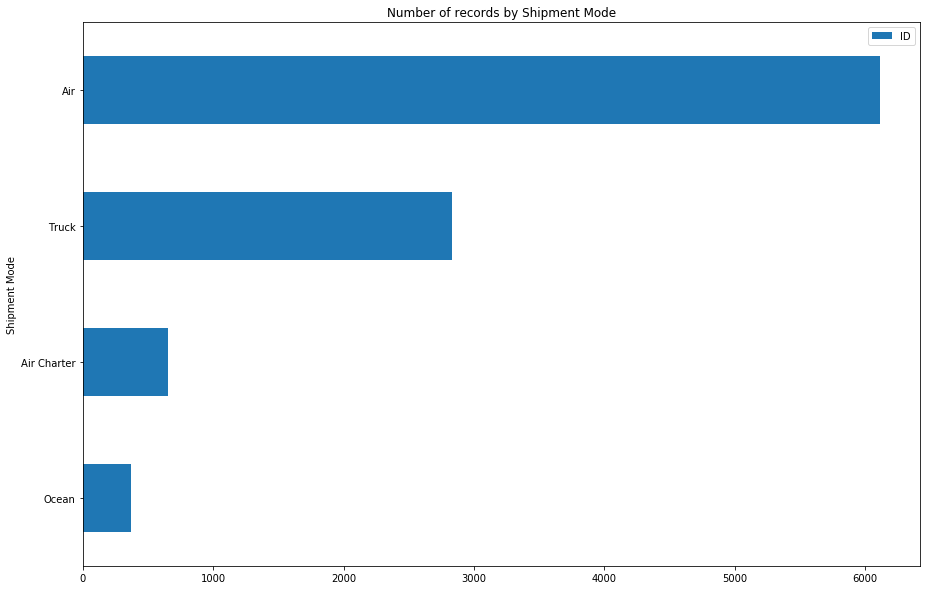

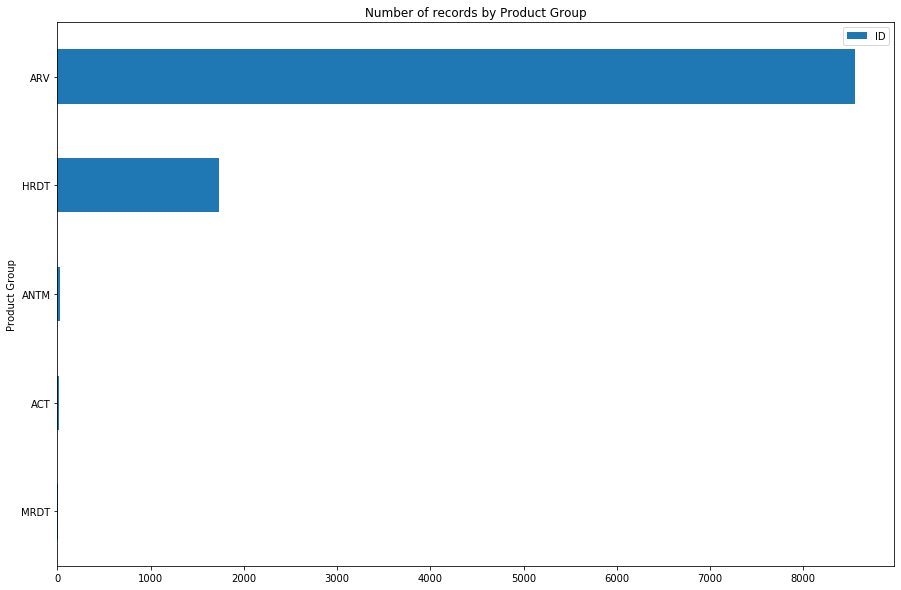

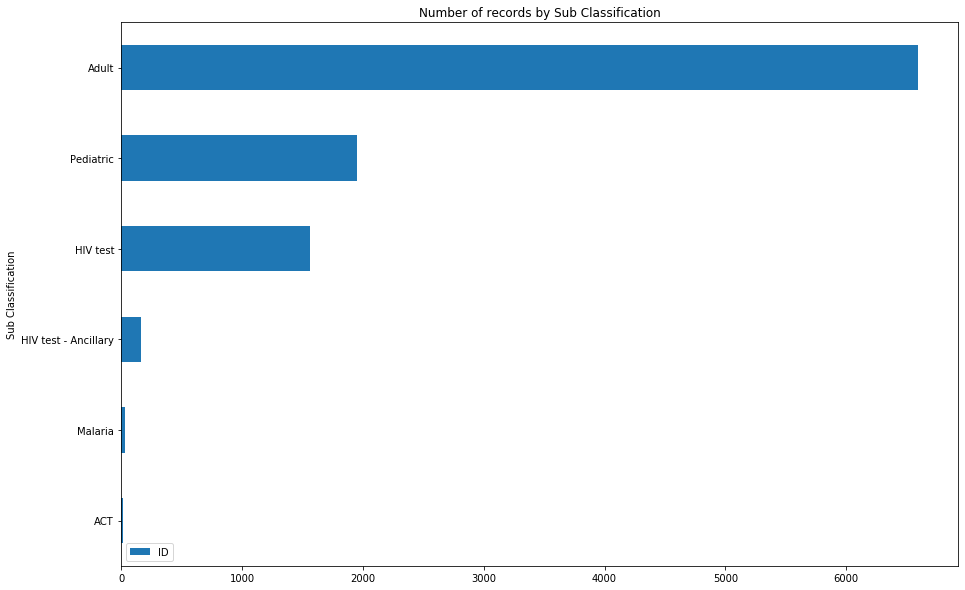

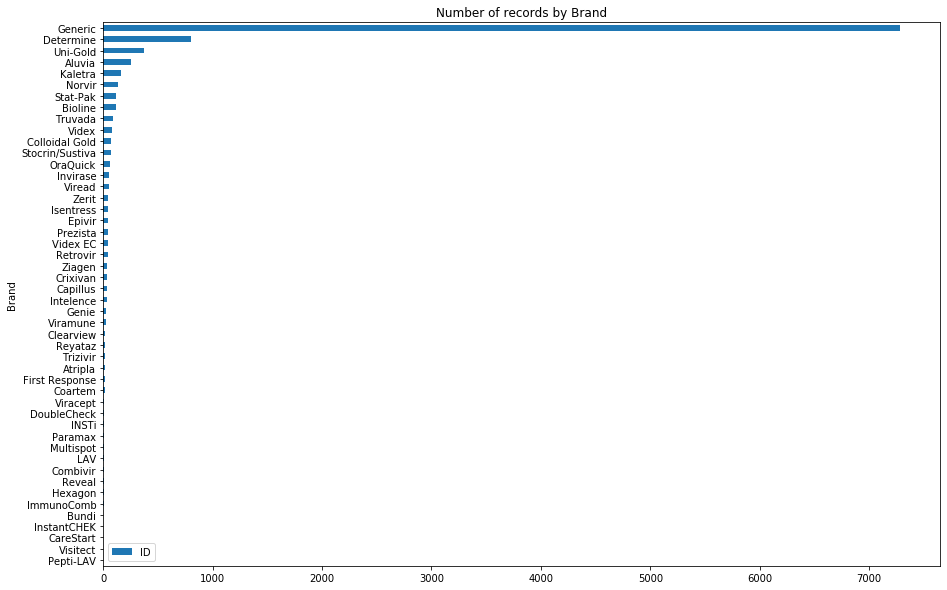

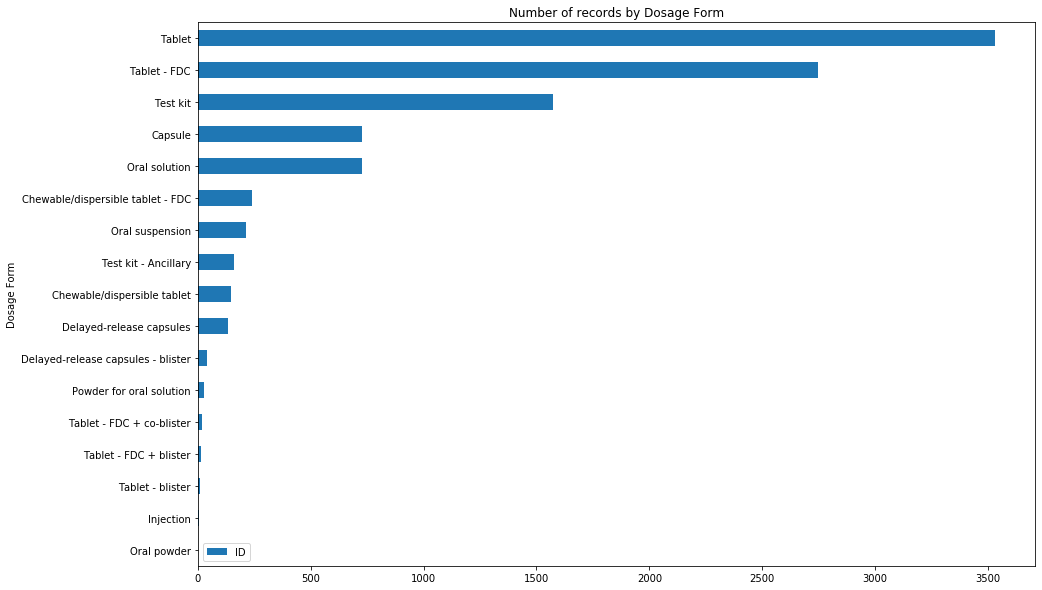

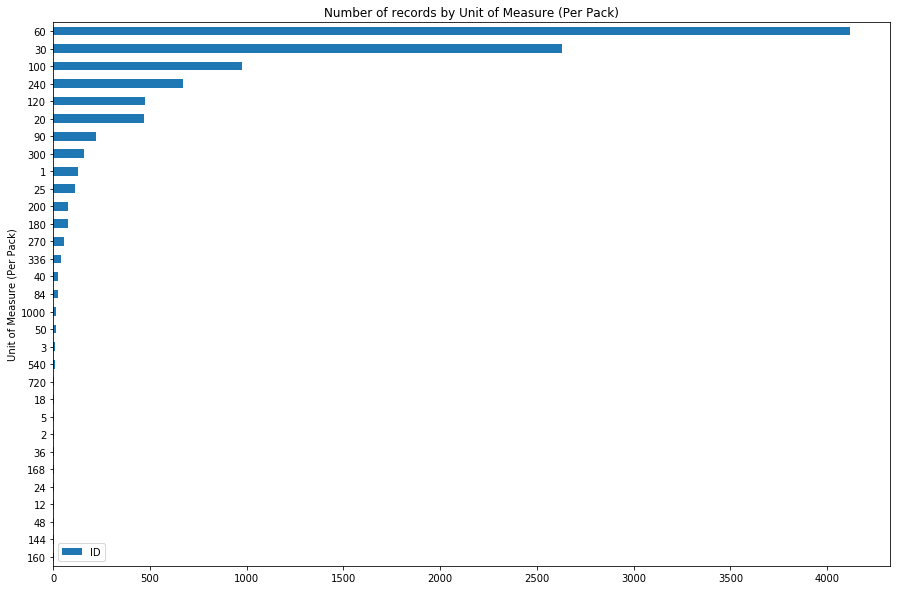

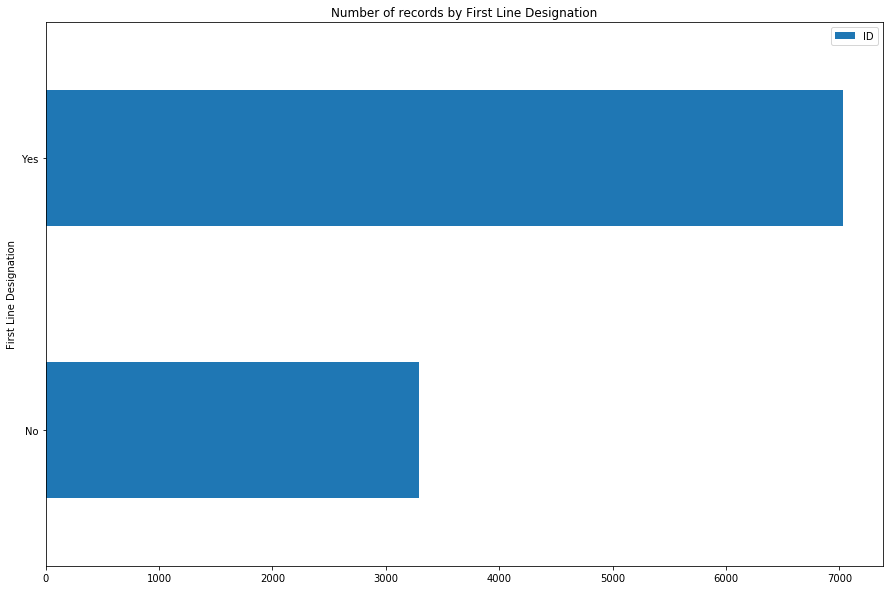

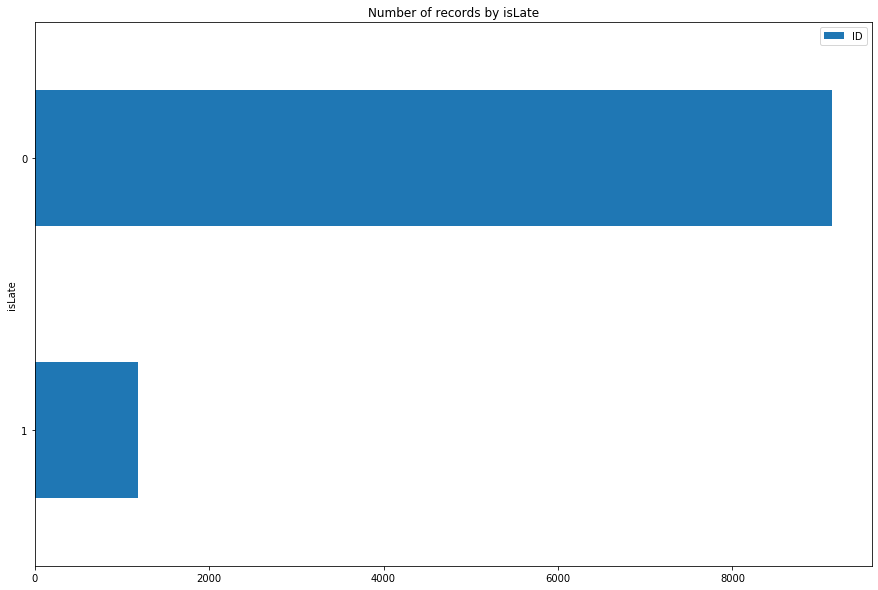

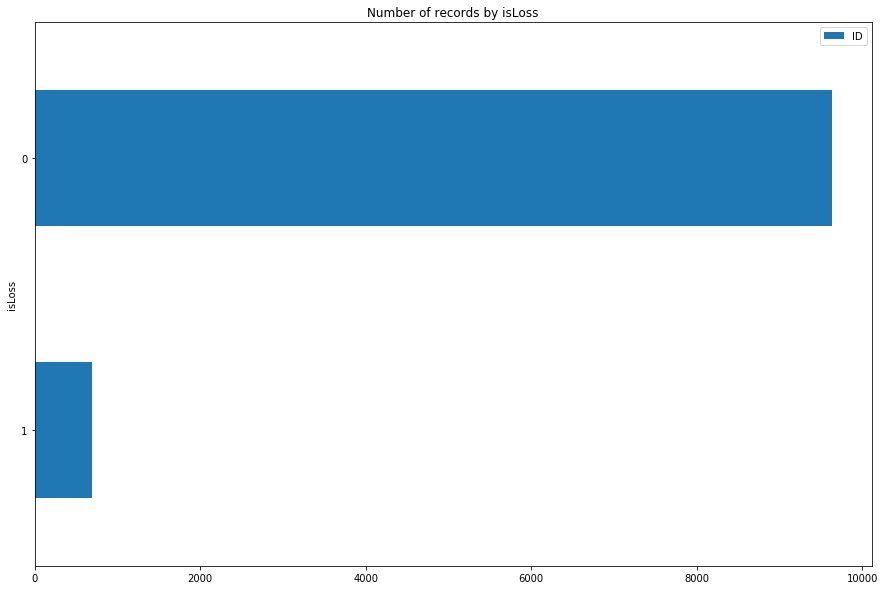

In [105]:
categoricalPlot(df, columnDf)